In [1]:
import re
import datetime
import scipy
import sys
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.collections as collections
import seaborn as sns
from scipy.signal import savgol_filter
from scipy.optimize import minimize_scalar
import scipy.linalg as linalg


from sys import stdout
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, Binarizer, MinMaxScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split, cross_val_predict,cross_val_score , KFold
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, explained_variance_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_predict, cross_val_score, KFold , \
    cross_validate, StratifiedKFold

import pyod as pyod

import warnings
warnings.filterwarnings("ignore")

In [64]:
df = pd.read_csv("data_tieu_hat_full.csv")
df.head(2)

,Code2,Code3,extract_date_from_filename,ID_machine,Temperature,Humidity,901.398183,905.331226,909.259927,913.184288,...,1673.98141,1676.942091,1679.898431,1682.85043,1685.798089,1688.741406,1691.680383,1694.615018,1697.545313,1701.44562
0,00893_36,Hadanard1_100800_20220623_141053.csv,6/23/2022,2,34.29,85.91,0.830749,0.807264,0.816415,0.812683,...,-0.172542,-0.189900,-0.200437,-0.196828,-0.179310,-0.169280,-0.156739,-0.154597,-0.150397,-0.126200
1,00893_36,Hadanard1_100800_20220623_141110.csv,6/23/2022,2,34.48,85.26,0.704169,0.701405,0.692683,0.690105,...,-0.069185,-0.090661,-0.098000,-0.096262,-0.084292,-0.072022,-0.062244,-0.054861,-0.055234,-0.031353


In [65]:
wavelength = df.columns[6:]
wavelength = np.array(wavelength)
wavelength = wavelength.astype(float)

In [66]:
df_machine1 = df[df['ID_machine'] == 1]
df_machine2 = df[df['ID_machine'] == 2]

In [6]:
print(len(df_machine1))
print(len(df_machine2))

21344
12185


In [67]:
X1 = np.array(df_machine1.iloc[:,6:].mean(axis=0))
X2 = np.array(df_machine2.iloc[:,6:].mean(axis=0))

In [68]:
calibration_factor = X2 / X1
calibrated_array1 = X1 * calibration_factor

In [69]:
cross_corr = np.correlate(X1, X2, mode='same')
shift = np.argmax(cross_corr) - (len(X1) - 1)

In [70]:
df_machine1.iloc[:,6:] = df_machine1.iloc[:, 6:] * np.array(calibration_factor)

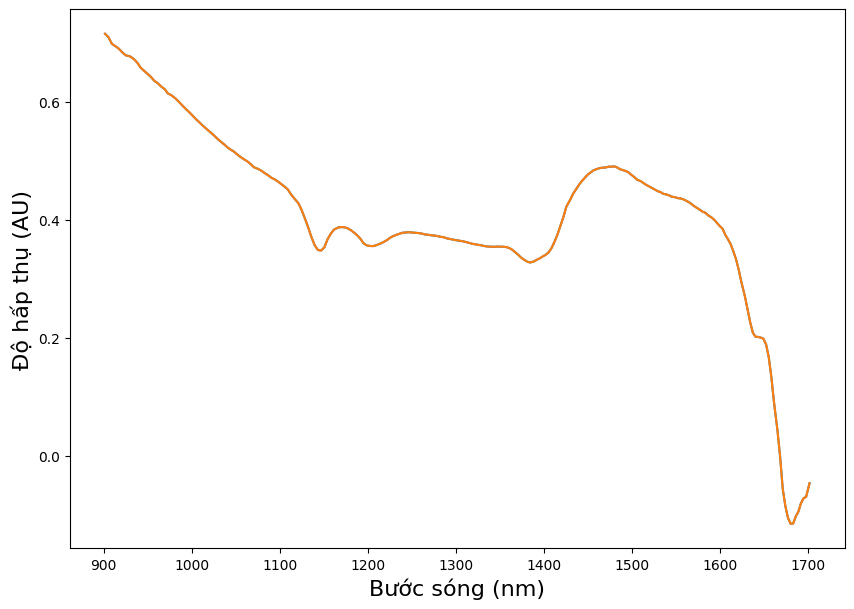

In [62]:
fig, ax = plt.subplots( figsize=(10,7))

#ax.plot(wavelength,X1)
ax.plot(wavelength,X2)
ax.plot(wavelength,calibrated_array1)

    #ax.set_title('Tổng hợp kết quả tiêu', fontsize=20)
ax.set_xlabel('Bước sóng (nm)', fontsize=16)
ax.set_ylabel('Độ hấp thụ (AU)', fontsize=16)
    #ax.set_ylim([-0.5, 2.5])
plt.show()

In [71]:
df2 = pd.concat([df_machine1, df_machine2])
df2 = df2.drop(columns=['Code3', 'Temperature', 'Humidity', 'ID_machine'])

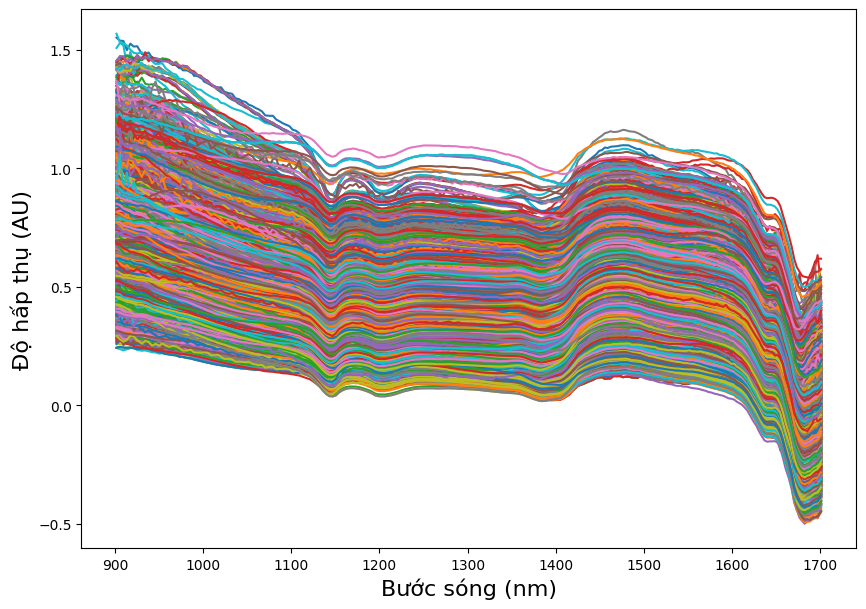

In [79]:
fig, ax = plt.subplots(figsize=(10,7))
for i in range(0,len(df2)):
    ax.plot(wavelength,df2.iloc[i,2:])

#ax.set_title('Tổng hợp kết quả tiêu', fontsize=20)
ax.set_xlabel('Bước sóng (nm)', fontsize=16)
ax.set_ylabel('Độ hấp thụ (AU)', fontsize=16)
#ax.set_ylim([-0.5, 2.5])
plt.show()

In [42]:
df2.head(2)

,Code2,extract_date_from_filename,901.398183,905.331226,909.259927,913.184288,917.104308,921.019987,924.931325,930.13969,...,1673.98141,1676.942091,1679.898431,1682.85043,1685.798089,1688.741406,1691.680383,1694.615018,1697.545313,1701.44562
781,02422_04,1/18/2022,0.578809,0.584925,0.531765,0.547899,0.524846,0.542817,0.515877,0.534259,...,-0.055715,-0.068215,-0.073980,-0.073108,-0.068069,-0.058943,-0.054608,-0.044094,-0.049330,-0.027817
782,02422_04,1/18/2022,0.588947,0.567802,0.581954,0.558516,0.567235,0.543199,0.543149,0.545374,...,-0.039689,-0.049857,-0.051372,-0.052202,-0.045543,-0.042256,-0.034892,-0.030659,-0.030369,-0.020981


In [74]:
a = df2[df2[df2.iloc[:,2:] <= -0.5].any(axis=1)].index
df2 = df2.drop(index=a, axis=0)
df2 = df2.reset_index(drop=True)

a = df2[df2[df2.iloc[:,2:] >= 2.0].any(axis=1)].index
df2 = df2.drop(index=a, axis=0)
df2 = df2.reset_index(drop=True)

In [78]:
a = df2[df2[df2.iloc[:,2:3] <= 0.2].any(axis=1)].index
df2 = df2.drop(index=a, axis=0)
df2 = df2.reset_index(drop=True)


In [51]:
df3 = df2.groupby(['Code2', 'extract_date_from_filename']).mean().reset_index()

In [52]:
df3

,Code2,extract_date_from_filename,901.398183,905.331226,909.259927,913.184288,917.104308,921.019987,924.931325,930.13969,...,1673.98141,1676.942091,1679.898431,1682.85043,1685.798089,1688.741406,1691.680383,1694.615018,1697.545313,1701.44562
0,00072_22,6/22/2022,0.696805,0.694536,0.683930,0.681593,0.677989,0.672134,0.666920,0.665350,...,-0.244438,-0.268946,-0.284671,-0.290617,-0.284363,-0.280592,-0.270036,-0.262460,-0.259066,-0.235076
1,00098_20,5/10/2022,0.667215,0.663787,0.657128,0.651254,0.646824,0.640313,0.636833,0.633799,...,-0.088541,-0.109104,-0.118821,-0.118140,-0.105249,-0.097256,-0.082442,-0.073941,-0.071475,-0.047976
2,00104_19,5/17/2022,0.630190,0.622485,0.611922,0.606690,0.601900,0.596823,0.592307,0.590210,...,-0.076098,-0.094049,-0.102897,-0.102961,-0.092513,-0.085450,-0.072823,-0.065195,-0.063294,-0.042446
3,00107_14,6/9/2022,0.625221,0.624891,0.614973,0.612170,0.605330,0.601373,0.594384,0.591528,...,-0.069778,-0.085487,-0.092928,-0.092309,-0.082449,-0.075906,-0.064702,-0.057701,-0.056230,-0.037453
4,00108_03,7/7/2022,0.808258,0.804390,0.792780,0.789594,0.785070,0.778403,0.771624,0.768505,...,-0.045578,-0.066033,-0.076268,-0.075970,-0.063849,-0.055188,-0.040658,-0.031489,-0.027828,-0.004475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252,08299_16,12/12/2021,0.680787,0.673323,0.660663,0.654655,0.650241,0.643846,0.639127,0.637321,...,-0.092684,-0.114853,-0.126209,-0.126253,-0.113317,-0.104618,-0.088948,-0.079669,-0.076945,-0.051543
253,08299_16,12/2/2021,0.753684,0.739269,0.724010,0.717190,0.713899,0.709583,0.706446,0.706176,...,-0.122163,-0.151079,-0.165806,-0.165455,-0.148118,-0.136007,-0.114653,-0.101377,-0.097079,-0.064658
254,08299_16,12/24/2021,0.574499,0.568352,0.556840,0.551193,0.543096,0.539986,0.537084,0.535189,...,-0.005175,-0.002908,-0.001637,-0.002345,-0.004933,-0.006057,-0.007952,-0.008213,-0.008716,-0.007188
255,08299_16,2/17/2022,0.704999,0.694933,0.684519,0.676212,0.671384,0.665252,0.661387,0.656275,...,-0.109296,-0.137951,-0.153515,-0.155174,-0.139694,-0.129545,-0.109539,-0.097737,-0.094055,-0.062735


In [54]:
print(len(df3['Code2'].unique()))

151


In [135]:
df2.to_csv("./data_tieu_hat_full_after_remove_outlier.csv", encoding="utf-8-sig")

In [81]:
X = df2.iloc[:,2:].dropna()

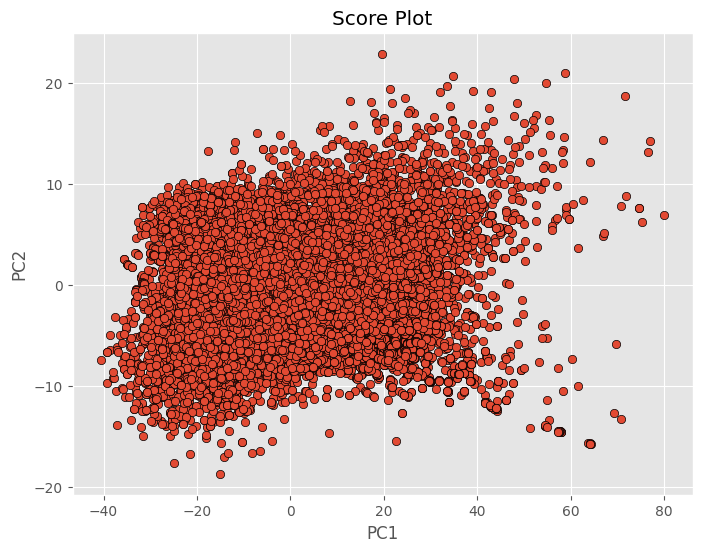

In [82]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Define the PCA object
pca = PCA()
 
# Run PCA on scaled data and obtain the scores array
T = pca.fit_transform(StandardScaler().fit_transform(X))
 
# Score plot of the first 2 PC
fig = plt.figure(figsize=(8,6))
with plt.style.context(('ggplot')):
    plt.scatter(T[:, 0], T[:, 1], edgecolors='k', cmap='jet')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('Score Plot')
plt.show()

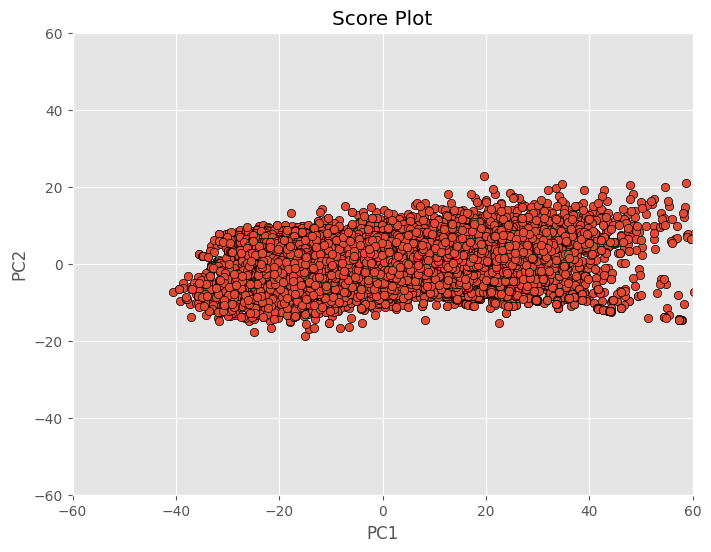

In [83]:
fig = plt.figure(figsize=(8,6))
with plt.style.context(('ggplot')):
    plt.scatter(T[:, 0], T[:, 1], edgecolors='k', cmap='jet')
    plt.xlim((-60, 60))
    plt.ylim((-60, 60))
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('Score Plot')
plt.show()

In [84]:
from sklearn.covariance import EmpiricalCovariance, MinCovDet
 
# fit a Minimum Covariance Determinant (MCD) robust estimator to data 
robust_cov = MinCovDet().fit(T[:,:5])
 
# Get the Mahalanobis distance
m = robust_cov.mahalanobis(T[:,:5])

In [31]:
np.arange(len(m))

array([    0,     1,     2, ..., 33525, 33526, 33527])

In [33]:
m[m>30000]

array([33593.02465051])

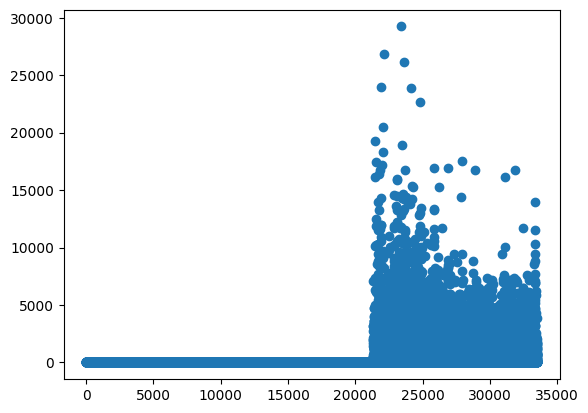

In [85]:
plt.scatter(np.arange(len(m)), np.array(m) )

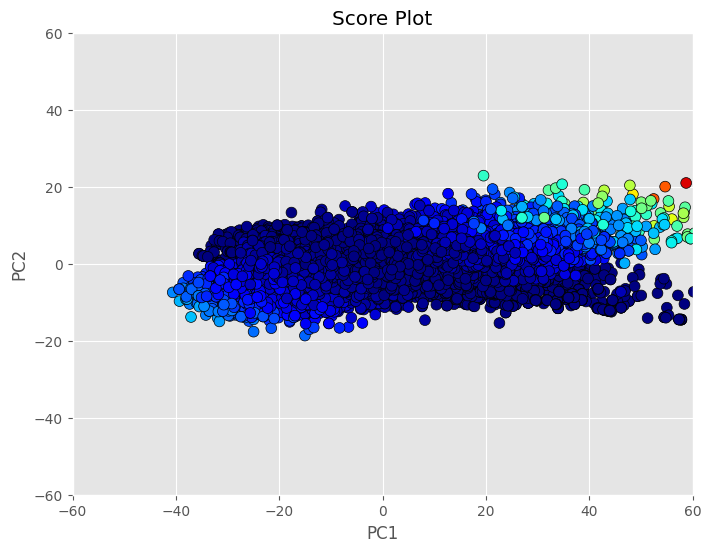

In [86]:
colors = [plt.cm.jet(float(i)/max(m)) for i in m]
fig = plt.figure(figsize=(8,6))
with plt.style.context(('ggplot')):
    plt.scatter(T[:, 0], T[:, 1], c=colors, edgecolors='k', s=60)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.xlim((-60, 60))
    plt.ylim((-60, 60))
    plt.title('Score Plot')
plt.show()

In [89]:
sorted_m = sorted(m)
value_95percentile = np.percentile(sorted_m,95)
value_95percentile

2679.3865343501993

In [122]:
df2[df2.iloc[:, 2:].isna()].any(axis=1)

0        False
1        False
2        False
3        False
4        False
         ...  
33510    False
33511    False
33512    False
33513    False
33514    False
Length: 33515, dtype: bool

In [128]:
# Select columns 2 to 10 (i.e., 'col2' to 'col10') and find rows with NaN
rows_with_nan = df2.iloc[:, 2:].isna().any(axis=1)
rows_with_nan_df = df2[rows_with_nan]
df2 = df2[~rows_with_nan]

In [129]:
df2['mahalanobis_distance'] = m

In [133]:
a = df2[df2[df2.iloc[:,-1:] >= value_95percentile].any(axis=1)].index
df2 = df2.drop(index=a, axis=0)
df2 = df2.reset_index(drop=True)

In [88]:
# Sample data
data = [10, 5, 2, 8, 9, 7, 1, 6, 3, 4]

# Sort the data in ascending order
sorted_data = sorted(data)

# Calculate the 95th percentile
percentile_95 = np.percentile(sorted_data, 95)

print(f"Sorted data: {sorted_data}")

array([  3.1362629 ,  10.2764435 ,   2.87800421, ..., 692.96402725,
        22.6767473 , 306.83984752])

In [ ]:
from sklearn.covariance import EmpiricalCovariance, MinCovDet
 
# fit a Minimum Covariance Determinant (MCD) robust estimator to data 
robust_cov = MinCovDet().fit(T[:,:5])
 
# Get the Mahalanobis distance
m = robust_cov.mahalanobis(T[:,:5])

# Label check

In [155]:
df_hoaly = pd.read_excel("./Mã hóa mẫu tiêu.xlsx")
df_hoaly = df_hoaly[['Mã ghi trên túi', 'Nguồn gốc']]
df_hoaly

,Mã ghi trên túi,Nguồn gốc
0,00523_01,Đăk Lăk
1,00425_02,Đăk Lăk
2,00534_03,Đăk Lăk
3,00423_04,Đăk Lăk
4,00506_05,Đăk Lăk
...,...,...
159,02469_32,Gia Lai
160,08297_04,Quảng Trị
161,08297_05,Quảng Trị
162,08297_06,Quảng Trị


In [137]:
df3 = df2.groupby(['Code2', 'extract_date_from_filename']).mean().reset_index()
df3.head(2)


,Code2,extract_date_from_filename,901.398183,905.331226,909.259927,913.184288,917.104308,921.019987,924.931325,930.13969,...,1676.942091,1679.898431,1682.85043,1685.798089,1688.741406,1691.680383,1694.615018,1697.545313,1701.44562,mahalanobis_distance
0,00072_22,6/22/2022,0.732877,0.732421,0.722383,0.719951,0.716312,0.711084,0.706271,0.705152,...,-0.214952,-0.230325,-0.236006,-0.229403,-0.225497,-0.214732,-0.207201,-0.203185,-0.179501,1245.186056
1,00098_20,5/10/2022,0.667215,0.663787,0.657128,0.651254,0.646824,0.640313,0.636833,0.633799,...,-0.109104,-0.118821,-0.118140,-0.105249,-0.097256,-0.082442,-0.073941,-0.071475,-0.047976,5.681129


In [138]:
df3 = df3.replace({'02415-07':'02415_07', 
            '02422-09':'02422_09',
            '00389_02':'00398_02',
            '09625_15':'06925_15'})

In [156]:
df3['nguon_goc'] = pd.Series(dtype='int')

In [157]:
for i in range(len(df_hoaly)):
    df3['nguon_goc'] = df3.apply(lambda x: df_hoaly['Nguồn gốc'][i] if ((x['Code2'] == df_hoaly['Mã ghi trên túi'][i])) else x['nguon_goc'], axis=1)

In [158]:
df3['nguon_goc'].unique()

array(['Bà Rịa - Vũng Tàu', 'Đồng Nai', 'Đăk Nông', 'Đăk Lăk', 'Gia Lai',
       'Quảng Trị'], dtype=object)

In [154]:
df3[df3['c'].isna()]['Code2'].unique()

array(['00398_02', '02469_32', '08297_04', '08297_05', '08297_06',
       '08298_06'], dtype=object)

In [160]:
df3

,Code2,extract_date_from_filename,901.398183,905.331226,909.259927,913.184288,917.104308,921.019987,924.931325,930.13969,...,1679.898431,1682.85043,1685.798089,1688.741406,1691.680383,1694.615018,1697.545313,1701.44562,mahalanobis_distance,nguon_goc
0,00072_22,6/22/2022,0.732877,0.732421,0.722383,0.719951,0.716312,0.711084,0.706271,0.705152,...,-0.230325,-0.236006,-0.229403,-0.225497,-0.214732,-0.207201,-0.203185,-0.179501,1245.186056,Bà Rịa - Vũng Tàu
1,00098_20,5/10/2022,0.667215,0.663787,0.657128,0.651254,0.646824,0.640313,0.636833,0.633799,...,-0.118821,-0.118140,-0.105249,-0.097256,-0.082442,-0.073941,-0.071475,-0.047976,5.681129,Đồng Nai
2,00104_19,5/17/2022,0.630190,0.622485,0.611922,0.606690,0.601900,0.596823,0.592307,0.590210,...,-0.102897,-0.102961,-0.092513,-0.085450,-0.072823,-0.065195,-0.063294,-0.042446,3.776926,Đồng Nai
3,00107_14,6/9/2022,0.625221,0.624891,0.614973,0.612170,0.605330,0.601373,0.594384,0.591528,...,-0.092928,-0.092309,-0.082449,-0.075906,-0.064702,-0.057701,-0.056230,-0.037453,3.664393,Đồng Nai
4,00108_03,7/7/2022,0.786627,0.782108,0.770412,0.766682,0.761894,0.754998,0.747655,0.744247,...,-0.108272,-0.107998,-0.095491,-0.086624,-0.071778,-0.062545,-0.058417,-0.034746,726.573176,Đồng Nai
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252,08299_16,12/12/2021,0.680787,0.673323,0.660663,0.654655,0.650241,0.643846,0.639127,0.637321,...,-0.126209,-0.126253,-0.113317,-0.104618,-0.088948,-0.079669,-0.076945,-0.051543,5.014694,Quảng Trị
253,08299_16,12/2/2021,0.753684,0.739269,0.724010,0.717190,0.713899,0.709583,0.706446,0.706176,...,-0.165806,-0.165455,-0.148118,-0.136007,-0.114653,-0.101377,-0.097079,-0.064658,6.195618,Quảng Trị
254,08299_16,12/24/2021,0.574499,0.568352,0.556840,0.551193,0.543096,0.539986,0.537084,0.535189,...,-0.001637,-0.002345,-0.004933,-0.006057,-0.007952,-0.008213,-0.008716,-0.007188,26.328736,Quảng Trị
255,08299_16,2/17/2022,0.704999,0.694933,0.684519,0.676212,0.671384,0.665252,0.661387,0.656275,...,-0.153515,-0.155174,-0.139694,-0.129545,-0.109539,-0.097737,-0.094055,-0.062735,9.014544,Quảng Trị


In [162]:
len(df['Code2'].unique())

151

In [170]:
df3.groupby(['nguon_goc'])['nguon_goc'].count()

nguon_goc
Bà Rịa - Vũng Tàu     35
Gia Lai               30
Quảng Trị            106
Đăk Lăk               39
Đăk Nông              29
Đồng Nai              18
Name: nguon_goc, dtype: int64

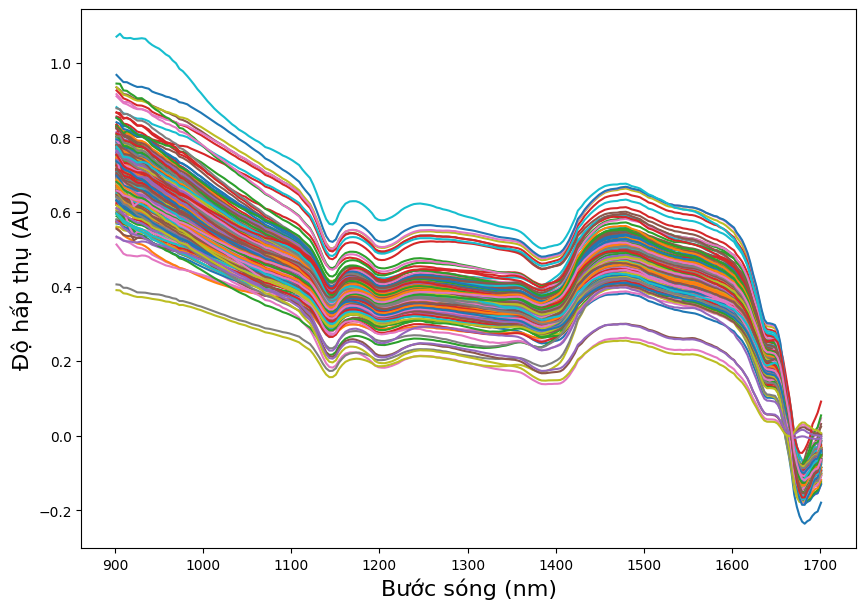

In [173]:
fig, ax = plt.subplots(figsize=(10,7))
for i in range(0,len(df3)):
    ax.plot(wavelength,df3.iloc[i,2:-2])

#ax.set_title('Tổng hợp kết quả tiêu', fontsize=20)
ax.set_xlabel('Bước sóng (nm)', fontsize=16)
ax.set_ylabel('Độ hấp thụ (AU)', fontsize=16)
#ax.set_ylim([-0.5, 2.5])
plt.show()

In [174]:
X = df3.iloc[:,2:-2]
y = df3['nguon_goc']

In [182]:
import numpy as np
from DataLoad.DataLoad import SetSplit, LoadNirtest
from Preprocessing.Preprocessing import Preprocessing
from WaveSelect.WaveSelcet import SpctrumFeatureSelcet
# from Plot.SpectrumPlot import plotspc
# from Plot.SpectrumPlot import ClusterPlot
from Simcalculation.SimCa import Simcalculation
from Clustering.Cluster import Cluster
#from Regression.Rgs import QuantitativeAnalysis
#from Classification.Cls import QualitativeAnalysis

In [187]:
X_SNV = Preprocessing('SNV', X.values)

257 228


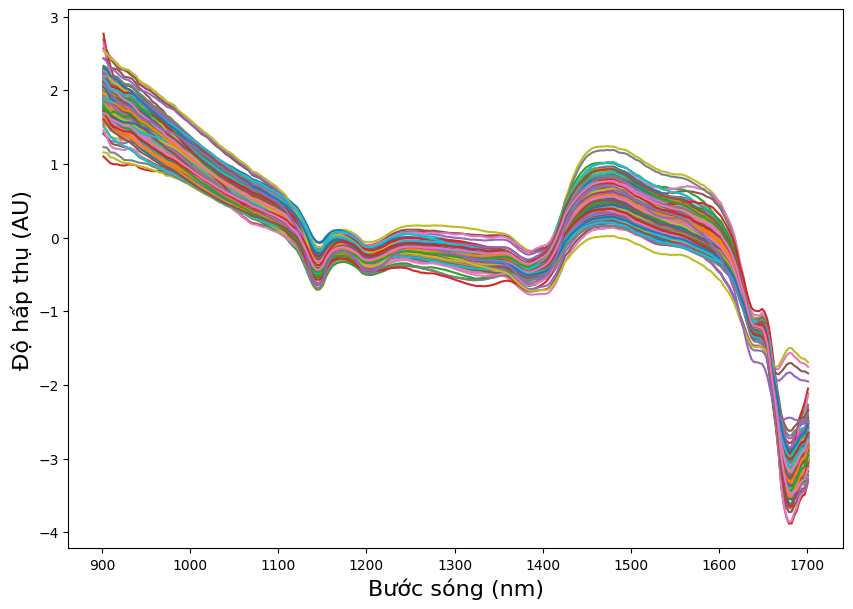

In [189]:
fig, ax = plt.subplots(figsize=(10,7))
for i in range(0,len(X_SNV)):
    ax.plot(wavelength,X_SNV[i])

#ax.set_title('Tổng hợp kết quả tiêu', fontsize=20)
ax.set_xlabel('Bước sóng (nm)', fontsize=16)
ax.set_ylabel('Độ hấp thụ (AU)', fontsize=16)
#ax.set_ylim([-0.5, 2.5])
plt.show()

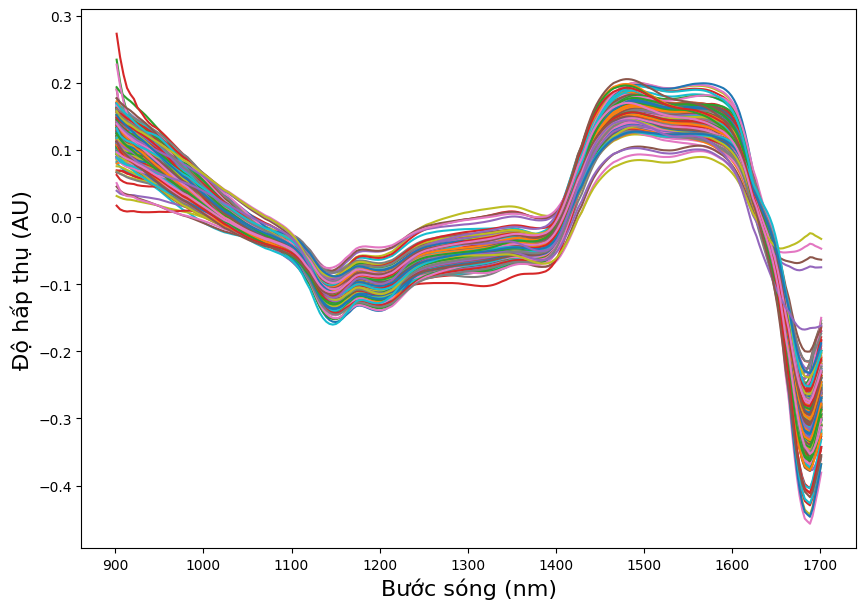

In [194]:
X_MSS = Preprocessing('DT', X.values)
fig, ax = plt.subplots(figsize=(10,7))
for i in range(0,len(X_MSS)):
    ax.plot(wavelength,X_MSS[i])

#ax.set_title('Tổng hợp kết quả tiêu', fontsize=20)
ax.set_xlabel('Bước sóng (nm)', fontsize=16)
ax.set_ylabel('Độ hấp thụ (AU)', fontsize=16)
#ax.set_ylim([-0.5, 2.5])
plt.show()

In [188]:
X_SNV

array([[ 2.01409943,  2.01174128,  1.95981885, ..., -2.84845152,
        -2.82768053, -2.70517148],
       [ 1.73534851,  1.71283378,  1.6690979 , ..., -3.13277864,
        -3.11658133, -2.9622325 ],
       [ 1.85360516,  1.79838106,  1.72268315, ..., -3.12998476,
        -3.11636201, -2.96695052],
       ...,
       [ 2.08945488,  2.04108271,  1.95049167, ..., -2.49623309,
        -2.50019296, -2.48816375],
       [ 1.60223758,  1.54099615,  1.47764028, ..., -3.28128451,
        -3.25888493, -3.06834602],
       [ 1.69306333,  1.66996855,  1.60886336, ..., -3.30039304,
        -3.28160294, -3.12826529]])